<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Overview</a></span></li></ul></li><li><span><a href="#Load-the-Data" data-toc-modified-id="Load-the-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load the Data</a></span></li><li><span><a href="#Model-the-Data-with-PLS" data-toc-modified-id="Model-the-Data-with-PLS-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model the Data with PLS</a></span><ul class="toc-item"><li><span><a href="#Training" data-toc-modified-id="Training-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Testing</a></span></li></ul></li><li><span><a href="#Optimizing-the-Model" data-toc-modified-id="Optimizing-the-Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Optimizing the Model</a></span></li><li><span><a href="#Outlier-Detection" data-toc-modified-id="Outlier-Detection-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Outlier Detection</a></span><ul class="toc-item"><li><span><a href="#Step-3" data-toc-modified-id="Step-3-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Step 3</a></span></li><li><span><a href="#Step-4" data-toc-modified-id="Step-4-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Step 4</a></span></li><li><span><a href="#Step-5" data-toc-modified-id="Step-5-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Step 5</a></span></li></ul></li></ul></div>

In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook

import imblearn
import sklearn

from sklearn.model_selection import GridSearchCV

import sys
sys.path.append('../../')
import chemometrics

import numpy as np
import pandas as pd

import watermark
%load_ext watermark

/home/nam/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/nam/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/nam/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and wil

Overview
-------------

This is an example of using PLS to create a model, following the procedures outlined in ["Detection of Outliers in Projection-Based Modeling," Rodionova and Pomerantsev, Analytical
    Chemistry 92 (2020) 2656−2664.](https://doi.org/10.1021/acs.analchem.9b04611)
    
Figure 1 from this paper illustrates the workflow:
![](./pls_example_fig1.png)

In [2]:
%watermark -t -m -v --iversions

watermark 2.0.2
numpy     1.21.4
sklearn   0.22.2.post1
json      2.0.9
imblearn  0.5.0
pandas    0.25.1
15:27:53 

CPython 3.7.4
IPython 7.8.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-166-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


# Load the Data

In [5]:
# Let's load some data from the tests/ for this example
df = pd.read_csv('../tests/data/pls_train.csv')

In [6]:
df

,Group,Name,Water,9000,9016,9032,9048,9064,9080,9096,...,10728,10744,10760,10776,10792,10808,10824,10840,10856,10872
0,1,psh1079,13.1,1.200471,1.200235,1.197285,1.191587,1.182786,1.170456,1.154333,...,0.947764,0.911444,0.874897,0.838401,0.802317,0.767152,0.733518,0.702013,0.673171,0.647416
1,1,psh1080,13.1,1.118446,1.120228,1.119543,1.116151,1.109550,1.099261,1.085294,...,1.019738,0.986162,0.952236,0.918314,0.884795,0.852187,0.821023,0.791809,0.765117,0.741465
2,1,psh1082,12.5,1.151631,1.153625,1.153154,1.149782,1.142985,1.132223,1.117273,...,0.960466,0.920775,0.880692,0.840490,0.800624,0.761642,0.724088,0.688496,0.655518,0.625669
3,1,psh1104,11.3,1.249430,1.246106,1.240054,1.231071,1.218746,1.202648,1.182540,...,0.857823,0.811211,0.764474,0.717992,0.672193,0.627514,0.584488,0.543758,0.505945,0.471541
4,1,psh1108,11.8,1.249200,1.249285,1.246747,1.241193,1.232022,1.218881,1.201564,...,0.851214,0.805609,0.759625,0.713541,0.667789,0.622848,0.579296,0.537772,0.498901,0.463128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,1,psh1572,12.1,1.208627,1.206364,1.201533,1.193940,1.183109,1.168546,1.150101,...,0.920882,0.880061,0.839070,0.798221,0.757988,0.718879,0.681480,0.646393,0.614156,0.585222
100,1,psh1581,11.1,1.309433,1.306744,1.301490,1.293203,1.281229,1.265039,1.244515,...,0.786403,0.736794,0.687120,0.637611,0.588602,0.540568,0.494092,0.449807,0.408333,0.370142
101,1,psh1583,11.9,1.242202,1.241043,1.237199,1.230210,1.219605,1.205144,1.186659,...,0.885069,0.841860,0.798274,0.754636,0.711474,0.669237,0.628333,0.589353,0.552943,0.519681
102,1,psh1593,12.1,1.260220,1.259043,1.255041,1.247895,1.237305,1.222779,1.204197,...,0.858332,0.812683,0.766794,0.721072,0.675887,0.631626,0.588853,0.548129,0.510001,0.475069


In [7]:
raw_x = np.array(df.values[:,3:], dtype=float) # Extract features
raw_y = np.array(df['Water'].values, dtype=float) # Take the water content as the target

# Model the Data with PLS

In [10]:
from chemometrics.regressor.pls import PLS

## Training

In [17]:
model = PLS(n_components=1, alpha=0.05, gamma=0.01, scale_x=True)

In [18]:
_ = model.fit(raw_x, raw_y)

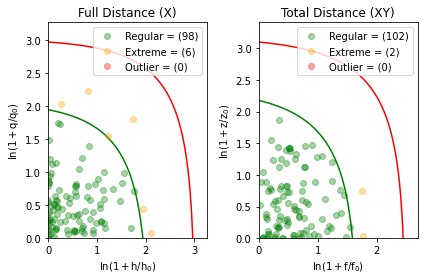

In [9]:
_ = model.visualize(raw_x, raw_y)

In [10]:
# We can predict the water content with model.predict(raw_x)
model.predict(raw_x)

array([[12.85925322],
       [12.99170771],
       [12.0644291 ],
       [11.35994524],
       [12.0004249 ],
       [12.96942061],
       [11.8951477 ],
       [11.89348395],
       [12.36920088],
       [12.37006495],
       [12.46654651],
       [11.70274461],
       [12.49127268],
       [13.2492494 ],
       [12.6971393 ],
       [11.73572268],
       [11.8234839 ],
       [12.03158665],
       [12.1121649 ],
       [11.9524923 ],
       [11.99322814],
       [12.39908269],
       [12.14624454],
       [12.18398517],
       [11.24459966],
       [11.54977815],
       [11.64547952],
       [13.12842557],
       [11.06497562],
       [11.54841086],
       [11.77807183],
       [11.91509363],
       [11.39989446],
       [11.28636669],
       [11.73845918],
       [11.53416868],
       [12.42932686],
       [12.66000371],
       [12.31264069],
       [12.13815894],
       [11.49554043],
       [11.8112226 ],
       [11.96543149],
       [11.5012801 ],
       [11.3594788 ],
       [11

In [22]:
# We can see what X data (if any) is extreme or is an outlier
extremes_mask, outliers_mask = model.check_x_outliers(raw_x)

In [23]:
# We could extract that data as follows:
extremes = raw_x[extremes_mask]
outliers = raw_x[outliers_mask]

In [28]:
# Number of X outliers, for example?
np.sum(outliers_mask)

0

In [29]:
# Number of X extremes, for example?
np.sum(extremes_mask)

6

In [37]:
# We can see what XY data (if any) is extreme or is an outlier
extremes_mask, outliers_mask = model.check_xy_outliers(raw_x, raw_y)

In [38]:
# Number of X outliers, for example?
np.sum(outliers_mask)

0

In [39]:
# Number of X extremes, for example?
np.sum(extremes_mask)

2

## Testing

In [48]:
df = pd.read_csv('../tests/data/pls_test.csv', header=None)
raw_x_t = np.array(df.values[:,3:], dtype=float)
raw_y_t = np.array(df.values[:,2], dtype=float)

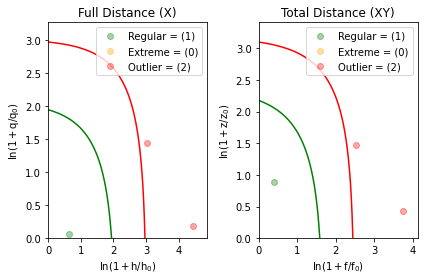

In [52]:
_ = model.visualize(raw_x_t, raw_y_t)

In [54]:
extremes_mask, outliers_mask = model.check_x_outliers(raw_x_t)

In [55]:
# Number of X extremes, for example?
np.sum(extremes_mask)

0

In [56]:
# Number of X outliers, for example?
np.sum(outliers_mask)

2

# Optimizing the Model

In [62]:
# Here I've use an imblearn pipeline, but you can also use scikit-learn's pipeline if you don't want to 
# do any class balancing.

pipeline = imblearn.pipeline.Pipeline(steps=[
    # Insert other preprocessing steps here...
    # ("smote", ScaledSMOTEENN(random_state=1)), # For example, class balancing
    ("pls", PLS(n_components=1, alpha=0.05, gamma=0.01, scale_x=True)
    )
])

# Hyperparameters of pipeline steps are given in standard notation: step__parameter_name
param_grid = [{
    # 'smote__k_enn':[1, 2, 3],
    # 'smote__k_smote':[1, 3, 3],
    # 'smote__kind_sel_enn':['all', 'mode'],
    'pls__n_components':np.arange(1, 10),
    # 'pls__alpha':[0.07, 0.05, 0.03, 0.01],
    # 'pls__scale_x': [True, False]
}]

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.KFold(n_splits=3, shuffle=True, random_state=0),
    error_score=0,
    refit=True
)

_ = gs.fit(raw_x, raw_y)

In [63]:
# The best parameters found can be accessed like this:
gs.best_params_

{'pls__n_components': 8}

In [64]:
gs.best_score_ # The best (default is R^2, coefficient of determination) score it recieved was...

0.904778746610679

In [65]:
# You can see detailed CV results here
gs.cv_results_

{'mean_fit_time': array([0.07696509, 0.12492784, 0.13781198, 0.15688562, 0.17262769,
        0.13886968, 0.08209928, 0.11616874, 0.11280362]),
 'std_fit_time': array([0.01645391, 0.0275922 , 0.02166494, 0.04144476, 0.02100859,
        0.01282735, 0.02183098, 0.00675425, 0.01107288]),
 'mean_score_time': array([0.00065128, 0.00063467, 0.0006063 , 0.00202529, 0.00062585,
        0.00057689, 0.00052396, 0.00057483, 0.00059764]),
 'std_score_time': array([9.83859880e-06, 6.66694405e-05, 7.63036305e-05, 1.93358856e-03,
        6.85065270e-05, 2.07066075e-05, 4.99111072e-05, 4.96074912e-05,
        4.80070016e-05]),
 'param_pls__n_components': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'pls__n_components': 1},
  {'pls__n_components': 2},
  {'pls__n_components': 3},
  {'pls__n_components': 4},
  {'pls__n_components': 5},
 

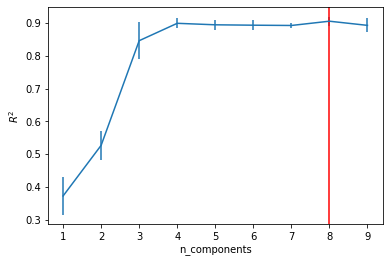

In [72]:
# For a 1D optimization you can easily visualize where the best value is
plt.errorbar(gs.cv_results_['param_pls__n_components'].data, 
             gs.cv_results_['mean_test_score'], 
             yerr=gs.cv_results_['std_test_score'])
plt.xlabel('n_components')
plt.ylabel(r'$R^2$')

plt.axvline(gs.best_params_['pls__n_components'], color='red')

In [76]:
# The refit=True (default) refits the model on the data in the end so you can use it directly on the test set.
gs.score(raw_x_t, raw_y_t)

0.4666574929118379

Text(0, 0.5, 'Predicted Water Content')

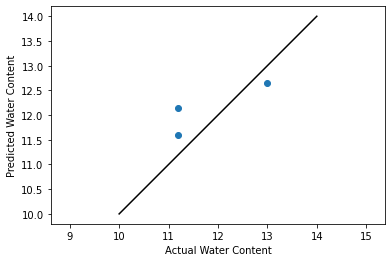

In [86]:
plt.plot(raw_y_t, gs.predict(raw_x_t), 'o')
plt.plot(np.linspace(10,14,100), np.linspace(10,14,100), 'k-')
plt.xlim(10,14)
plt.ylim(10,14)
_ = plt.axis('equal')
plt.xlabel('Actual Water Content')
plt.ylabel('Predicted Water Content')

# Outlier Detection

Steps 1 and 2 in the workflow at the beginning of this document are handled by the last step with CV. Now we can turn to optimizing the training set by removing outliers.

In [87]:
optimal_model = PLS(n_components=8, alpha=0.05, gamma=0.01, scale_x=True)
_ = optimal_model.fit(raw_x, raw_y)

## Step 3

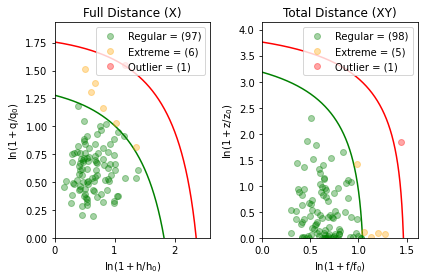

In [89]:
_ = optimal_model.visualize(raw_x, raw_y)

In [96]:
extremes, outliers = optimal_model.check_xy_outliers(raw_x, raw_y)

In [95]:
np.sum(outliers) # Indeed, we have 1 outlier

1

## Step 4

In [97]:
# Select data that is NOT an outlier (regular and extreme points)
new_x = raw_x[~outliers]
new_y = raw_y[~outliers]

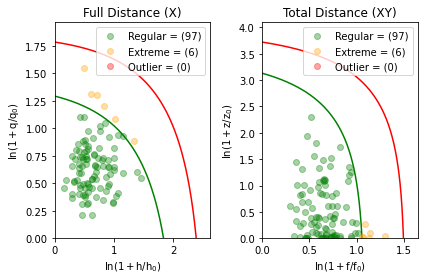

In [101]:
# After retraining the model we see there are no outliers - a "clean" training set
_ = optimal_model.fit(new_x, new_y)
_ = optimal_model.visualize(new_x, new_y)

## Step 5

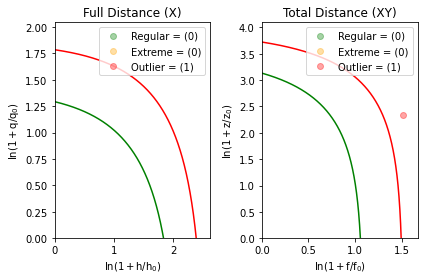

In [102]:
_ = optimal_model.visualize(raw_x[outliers], raw_y[outliers])

Outliers remain outliers, so the model is "stable" and Step 6 is not required.  This code always uses robust statistical methods for estimating internal parameters, so Step 7 is not performed.